In [1]:
pwd

'/home/wbaik/Code/data_science/playground_pytorch/Notebooks'

In [2]:
cd ..

/home/wbaik/Code/data_science/playground_pytorch


In [3]:
import iex_utils

In [4]:
import pandas as pd
import numpy as np
from iex_utils import create_df_from_symbols

In [5]:
spx_table = pd.read_csv('./iexdata/10K_data.csv')
sectors_list = list(set(spx_table['Sector']))
by_sectors = spx_table.groupby('Sector')

In [6]:
sectors_list[0]

'Materials'

In [7]:
random_sector = by_sectors.get_group(sectors_list[0])['Symbol'][:30]
temp_df = create_df_from_symbols(*random_sector)

In [9]:
columns_to_drop = list(filter(lambda x: 'close' not in x, temp_df.columns))

In [10]:
temp_df.drop(columns_to_drop, axis=1, inplace=True)

In [23]:
from compute_ratios import heatmap
from collections import defaultdict
%matplotlib inline

In [27]:
def some_strategy(prices, lb, hold):
    
    def get_portfolio_logic(price, lookback, lag):
        momentum = price.shift(lag).pct_change(lookback)
        ranks = momentum.rank(axis=1, ascending=False)
        best_ten = lambda x: list(map(lambda y: y 
                                      if y > price.shape[1] - 10 
                                      else 0, x))
        ranks = ranks.apply(best_ten, axis=1)
        return ranks
    
    compound = lambda x: (1 + x).prod() - 1
    daily_sr = lambda x: x.mean() / x.std()
    
    # Compute portfolio weights
    freq = '%dB' % hold
    port = get_portfolio_logic(prices, lb, lag=0)

    daily_rets = prices.pct_change()

    # `resample` merely loops over for each freq
    # Takes the first value of the resampled
    port = port.shift(1).resample(freq).first() # shift 1 for trading at the close
    returns = daily_rets.resample(freq).apply(compound)
    port_rets = (port * returns).sum(axis=1)

    return daily_sr(port_rets) * np.sqrt(252 / hold)

In [28]:
lookbacks = range(50, 100, 5)
holdings = range(50, 100, 5)
dd = defaultdict(dict) # dictionary of dictionary

for lb in lookbacks:
    for hold in holdings:
        dd[lb][hold] = some_strategy(temp_df, lb, hold)

ddf = pd.DataFrame(dd)
ddf.index.name = 'Holding Period'
ddf.columns.name = 'Lookback Period'

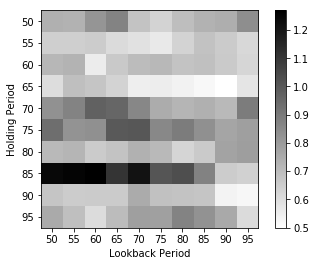

In [26]:
heatmap(ddf)